In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
data = pd.read_csv("filled.csv")
data = data.set_index(pd.to_datetime(data['date']))
data.describe()

,BC,N_CPC,PM-10,PM-2.5,PM-1.0,NO2,O3,SO2,CO,NO,NOX,TEMP,HUM
count,4584.000000,4584.00000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,1.309454,13.65188,15.132366,9.302461,7.259924,30.032402,48.139158,1.368459,0.312924,7.796788,41.608059,17.833411,70.848520
std,1.077179,7.90552,13.681307,5.844837,5.259162,20.904562,25.055354,0.767196,0.203269,17.780870,43.576061,5.875968,14.551874
min,0.110000,1.37600,0.600000,0.500000,0.333000,2.000000,1.000000,0.500000,0.100000,0.500000,1.000000,4.083000,19.383000
25%,0.682000,8.00300,8.991750,5.317000,3.383000,15.000000,32.000000,1.000000,0.200000,1.000000,18.000000,13.050000,61.567000
50%,1.037000,12.28950,13.625000,8.433000,6.383000,25.000000,48.139158,1.000000,0.200000,3.000000,30.000000,17.833411,70.848520
75%,1.437250,16.95800,17.817000,11.533000,9.167000,38.000000,63.000000,1.368459,0.312924,7.796788,45.000000,22.333000,82.158250
max,12.767000,73.49000,398.717000,76.833000,34.383000,132.000000,142.000000,13.000000,1.900000,255.000000,521.000000,34.983000,100.000000


In [2]:
data = data.sort_index()
data = data.reset_index(drop=True)
dates = data["date"]
data = data.drop(["date"], axis=1)

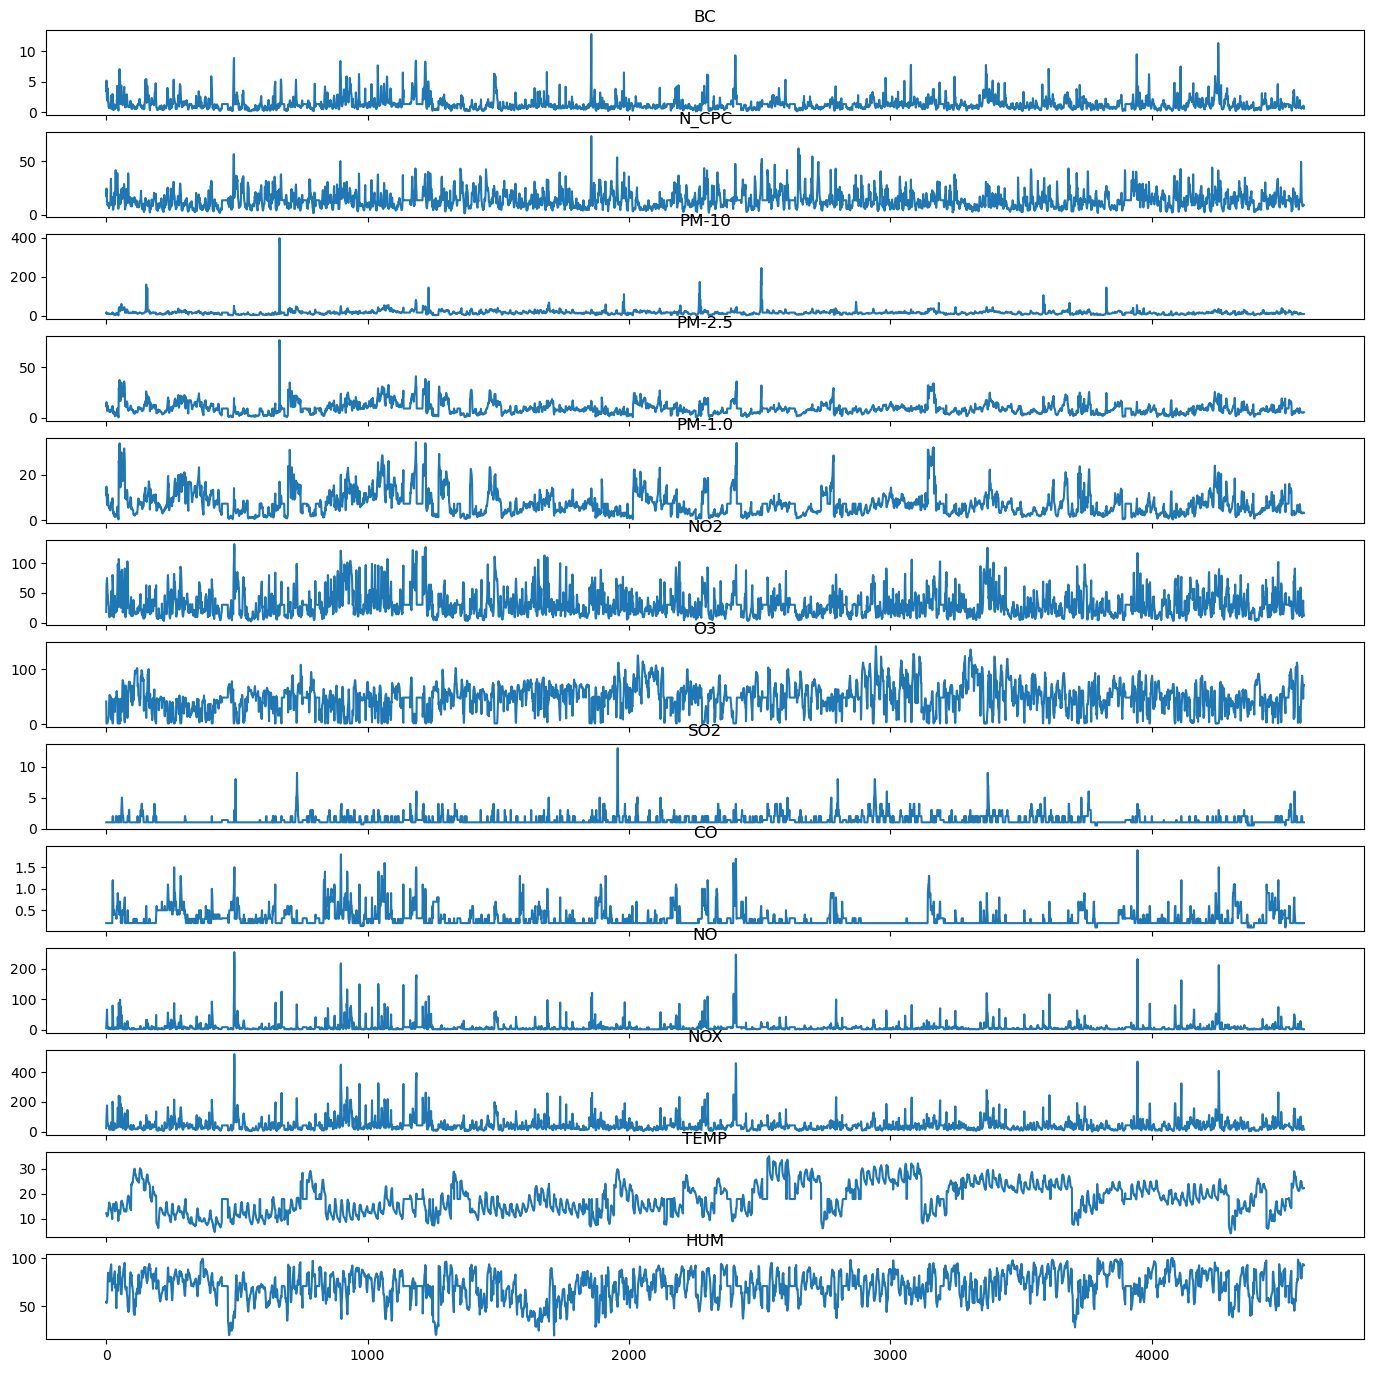

In [3]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(data, data.columns)

In [4]:
threshold = 6 # theshold a little high to retain some outliers
z_scores = np.abs((data - data.mean()) / data.std())
outliers = (z_scores > threshold).any(axis=1)
for column in data.columns:
    column_median = data[column].median()
    data.loc[outliers, column] = column_median

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') #disables GPU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten

In [6]:
# Scale the data to the range of [0, 1] for better performance
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [12]:
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length - 1):
        x.append(data[i:i+seq_length, 1:])  # Exclude BC concentration from input features
        y.append(data[i:i+seq_length, 0])  # BC concentration as the target variable
    return np.array(x), np.array(y)

seq_length = 24*5
x, y = create_sequences(scaled_data, seq_length)

# Split the dataset into training and validation sets
train_size = int(len(y) * 0.85)
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [13]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((3793, 120, 12), (3793, 120), (670, 120, 12), (670, 120))

In [14]:
model = Sequential()
model.add(LSTM(50, input_shape=(seq_length, x_train.shape[2]), return_sequences=True))
model.add(LSTM(30, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.00001)

In [16]:
history = model.fit(x_train, y_train, epochs=500, batch_size=64, validation_data=(x_val, y_val), callbacks=[reduce_lr, early_stopping])

Epoch 1/500
60/60 [==============================] - 5s 53ms/step - loss: 0.0157 - val_loss: 0.0175 - lr: 0.0010
Epoch 2/500
60/60 [==============================] - 3s 48ms/step - loss: 0.0151 - val_loss: 0.0170 - lr: 0.0010
Epoch 3/500
60/60 [==============================] - 3s 49ms/step - loss: 0.0145 - val_loss: 0.0165 - lr: 0.0010
Epoch 4/500
60/60 [==============================] - 3s 49ms/step - loss: 0.0144 - val_loss: 0.0166 - lr: 0.0010
Epoch 5/500
60/60 [==============================] - 3s 49ms/step - loss: 0.0144 - val_loss: 0.0167 - lr: 0.0010
Epoch 6/500
60/60 [==============================] - 3s 49ms/step - loss: 0.0143 - val_loss: 0.0169 - lr: 0.0010
Epoch 7/500
60/60 [==============================] - 3s 49ms/step - loss: 0.0143 - val_loss: 0.0168 - lr: 0.0010
Epoch 8/500
60/60 [==============================] - 3s 50ms/step - loss: 0.0143 - val_loss: 0.0166 - lr: 0.0010
Epoch 9/500
60/60 [==============================] - 3s 49ms/step - loss: 0.0143 - val_loss: 0.0

In [18]:
y_pred = model.predict(x_val)

21/21 [==============================] - 1s 8ms/step


In [19]:
y_val[:, -1].reshape(-1, 1).shape

(670, 1)

[1.30945371 1.30945371 1.30945371 1.30945371 1.30945371 1.30945371
 1.30945371 1.30945371 1.30945371 1.30945371 1.419      0.831
 0.516      0.661      0.781      1.345      2.187      2.893
 2.318      1.782      0.807      1.097      0.553      0.365
 0.523      0.553      0.495      0.602      0.787      2.38
 5.24       1.037      7.01       1.84       1.037      1.512
 4.216      1.191      1.205      0.893      1.637      2.097
 3.206      1.733      0.542      0.596      0.393      0.419
 0.492      0.618      1.25       0.842      1.913      0.737
 1.389      0.666      0.886      0.966      0.977      1.245
 1.276      0.658      1.017      0.808      0.969      1.25
 2.397      2.672      1.286      1.225      2.614      2.761
 1.616      1.282      1.399      0.984      2.064      4.455
 6.211      5.416      2.689      2.015      1.877      1.148
 0.856      0.806      0.55       0.663      0.771      1.056
 1.62       1.788      2.125      1.966      2.018      1.301
 1.31

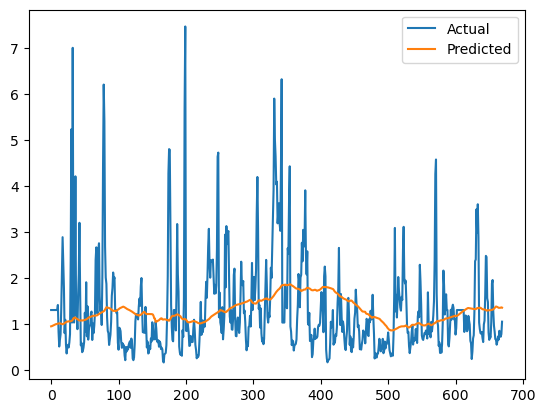

In [20]:
y_val_actual = scaler.inverse_transform(np.hstack((y_val[:, -1].reshape(-1, 1), x_val[:, -1])))[:, 0]
y_pred_actual = scaler.inverse_transform(np.hstack((y_pred[:, -1].reshape(-1, 1), x_val[:, -1])))[:, 0]

print(y_val_actual)
print(y_pred_actual)

mae = mean_absolute_error(y_val_actual, y_pred_actual)
mse = mean_squared_error(y_val_actual, y_pred_actual)
rmse = np.sqrt(mse)

print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

# Visualize the model's predictions
plt.plot(y_val_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.legend()
plt.show()